In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Configurations
file_path = r'C:\Users\Admin\prudential-life-insurance-assessment.xlsx'
file_path_test = r'C:\Users\Admin\test.csv'

In [4]:
#Read the input
df=pd.read_excel(file_path,sheet_name='train')

In [5]:
#Load the Test Data
df_test=pd.read_csv(file_path_test)

In [6]:
#Create a copy of train data
customer_data=df.copy()

In [7]:
#Getting the list of columns with more than 50 percent missing values.
Missing_col_list=customer_data.columns[customer_data.isnull().mean()>=0.5].to_list()

In [8]:
#these columns have more than 50 percent null values
Missing_col_list

['Family_Hist_3',
 'Family_Hist_5',
 'Medical_History_10',
 'Medical_History_15',
 'Medical_History_24',
 'Medical_History_32']

In [9]:
#We shall drop these columns in both training and test set
customer_data=customer_data.drop(Missing_col_list,axis=1)
df_test=df_test.drop(Missing_col_list,axis=1)

In [10]:
#Now lets re-engineer the other null value columns.
Missing_col_list_train=customer_data.columns[customer_data.isnull().any() == True].to_list()
Missing_col_list_test=df_test.columns[df_test.isnull().any() == True].to_list()

In [11]:
Missing_col_list_train

['Employment_Info_1',
 'Employment_Info_4',
 'Employment_Info_6',
 'Insurance_History_5',
 'Family_Hist_2',
 'Family_Hist_4',
 'Medical_History_1']

In [12]:
Missing_col_list_test

['Employment_Info_1',
 'Employment_Info_4',
 'Employment_Info_6',
 'Insurance_History_5',
 'Family_Hist_2',
 'Family_Hist_4',
 'Medical_History_1']

Both train and test sets have missing values in the same columns.Lets apply feature engineering on train set and propagate the same to test set.

In [13]:
#Filling the NA values with mean of the specific column in both train and test
for column in Missing_col_list_train:
    Mean=customer_data[column].mean()
    customer_data[column].fillna(Mean, inplace=True)
    df_test[column].fillna(Mean, inplace=True)

In [14]:
#Lets convert one categorical column(Product_Info_2) to numeric
#Trying to use monotonicity encoding technique
def CategoricalImputation_Monotonicity(X_train,X_test,variable,target_variable):
    ordered_labels=X_train.groupby([variable])[target_variable].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 1)}
    X_train[variable+'_ordered']=X_train[variable].map(ordinal_label)
    X_test[variable+'_ordered']=X_test[variable].map(ordinal_label)

In [15]:
CategoricalImputation_Monotonicity(customer_data,df_test,'Product_Info_2','Response')

In [16]:
customer_data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_ordered
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,8,9
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,4,13
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,8,14
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,8,16
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,8,6


Train Test split.

In [17]:
#deleting the id column and the categorical column as we have converted this to numerical.
customer_data=customer_data.drop(['Product_Info_2','Id'],axis=1)

In [18]:
#Taking X and y
X=customer_data.drop('Response',axis=1)
y=customer_data['Response']

In [19]:
y.value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

Class imbalance:Class 8 has highest number of records compared to other classes.

In [20]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='auto')
X_over_sample,y_over_sample=smote.fit_sample(X,y)

In [21]:
y_over_sample.value_counts()

8    19489
7    19489
6    19489
5    19489
4    19489
3    19489
2    19489
1    19489
Name: Response, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_over_sample,y_over_sample,test_size=0.3,stratify=y_over_sample)

Feature Selection -Linear Algorithms

Feature selection for linear algorithms are done using correlation.
Correlation is computed for continuous variables using the pandas corr method.
For categorical values we use chi-square.
And for categorical and continuous we use ANOVA.

In [23]:
list_of_features=customer_data.columns

In [24]:
numeric_columns=customer_data.columns[customer_data.dtypes=='float64'].tolist()
discrete_columns=customer_data.columns[customer_data.dtypes=='int64'].tolist()

In [25]:
discrete_columns

['Product_Info_1',
 'Product_Info_3',
 'Product_Info_5',
 'Product_Info_6',
 'Product_Info_7',
 'Employment_Info_2',
 'Employment_Info_3',
 'Employment_Info_5',
 'InsuredInfo_1',
 'InsuredInfo_2',
 'InsuredInfo_3',
 'InsuredInfo_4',
 'InsuredInfo_5',
 'InsuredInfo_6',
 'InsuredInfo_7',
 'Insurance_History_1',
 'Insurance_History_2',
 'Insurance_History_3',
 'Insurance_History_4',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9',
 'Family_Hist_1',
 'Medical_History_2',
 'Medical_History_3',
 'Medical_History_4',
 'Medical_History_5',
 'Medical_History_6',
 'Medical_History_7',
 'Medical_History_8',
 'Medical_History_9',
 'Medical_History_11',
 'Medical_History_12',
 'Medical_History_13',
 'Medical_History_14',
 'Medical_History_16',
 'Medical_History_17',
 'Medical_History_18',
 'Medical_History_19',
 'Medical_History_20',
 'Medical_History_21',
 'Medical_History_22',
 'Medical_History_23',
 'Medical_History_25',
 'Medical_History_26',
 'Medical_History_27',
 'Medi

In [26]:
corr_df=customer_data.corr()

In [27]:
corr_df[(corr_df['Response']>0.1)|(corr_df['Response']<-0.1)]['Response']

Product_Info_4            0.202434
Ins_Age                  -0.209610
Wt                       -0.351395
BMI                      -0.381601
Employment_Info_3        -0.116408
InsuredInfo_6             0.130476
Insurance_History_2      -0.122196
Medical_History_4         0.239896
Medical_History_6         0.159230
Medical_History_13        0.134863
Medical_History_16       -0.137542
Medical_History_23        0.286584
Medical_History_30       -0.114870
Medical_History_33        0.113112
Medical_History_39        0.220176
Medical_History_40        0.131519
Medical_Keyword_3        -0.257706
Medical_Keyword_15       -0.259169
Medical_Keyword_23       -0.113580
Medical_Keyword_25       -0.102023
Medical_Keyword_48       -0.159557
Response                  1.000000
Product_Info_2_ordered    0.261036
Name: Response, dtype: float64

Measure of correlation for Linear algorithms:

Chi-square Test: categorical vs categorical

In [28]:
#This function compares each categorical variable with the categorical target and 
#returns the list of significant features ordered by feature importance descending
def chisquareTest(customer_data,discrete_columns,target,technique):
    #Chi-square test using critical value 
    features_to_have=[]
    for i in range(len(discrete_columns)): 
        dataset_table=pd.crosstab(customer_data[discrete_columns[i]],customer_data[target])
        observed_values=dataset_table.values
        val=stats.chi2_contingency(dataset_table)
        expected_values=val[3]
        no_of_rows=len(dataset_table.iloc[0:8,0])
        no_of_cols=len(dataset_table.iloc[0,0:8])
        dof=(no_of_rows-1)*(no_of_cols-1)
        alpha=0.05 
        #Calculate chisquare using traditional formula((o-e)2/e)
        #chi_square=sum([(o-e)**2/e for o,e in zip(observed_values,expected_values)])
        #calculating scipy using the stats method
        chi_square=stats.chisquare(observed_values,expected_values,dof)
        chi_square_statistic=sum(chi_square[0])
        if(technique=='critical-value'):
            critical_value=stats.chi2.ppf(q=1-alpha,df=dof)
            if(chi_square_statistic>=critical_value):
                features_to_have.append(dict(Discretevar=discrete_columns[i],chisquare_value=chi_square_statistic))
        else:
            p_value=1-(stats.chi2.cdf(x=chi_square_statistic,df=dof))
            if(p_value<=0.05):
                features_to_have.append(dict(Discretevar=discrete_columns[i],Pvalue=p_value))
    chi2_df = pd.DataFrame(features_to_have)
    if chi2_df.shape[0]>0:
        if(technique=='critical-value'):
            chi2_df.sort_values(['chisquare_value'],ascending = True, inplace=True)
        else:
            chi2_df.sort_values(['Pvalue'],ascending = False, inplace=True)
        
    return chi2_df  

In [29]:
#Both p-value and critical value techniques are used.Specify any one in the last parameter.If it is empty by default p-value is used
#discrete_columns.remove('Response')
chisquare_df=chisquareTest(customer_data,discrete_columns,'Response','critical-value')

Anova Test:categorical vs continuous

In [30]:
#This function compares each continuous variable with the categorical target and 
#returns the list of significant features ordered by feature importance descending
def anovaTest(customer_data,numeric_columns,target):
    #Chi-square test using critical value 
    features_to_have=[]
    for i in range(len(numeric_columns)): 
        temp_df = customer_data[[numeric_columns[i], target]].dropna()
        f,p = stats.f_oneway(*[list(temp_df[temp_df[target]==name][numeric_columns[i]]) for name in set(temp_df[target])])
        features_to_have.append(dict(Continuousvar = numeric_columns[i], PValue = p))

    Anova_df = pd.DataFrame(features_to_have)
    if Anova_df.shape[0]>0:
        Anova_df = Anova_df[Anova_df['PValue']<=0.05]
        Anova_df.sort_values(['PValue'],ascending = False, inplace=True)
        
    return Anova_df  

In [31]:
anova_df=anovaTest(customer_data,numeric_columns,'Response')
anova_df

,Continuousvar,PValue
8,Insurance_History_5,4.278185e-05
6,Employment_Info_4,3.307724e-20
5,Employment_Info_1,4.806949e-75
7,Employment_Info_6,3.190024e-108
9,Family_Hist_2,2.684236e-111
11,Medical_History_1,3.879757e-135
10,Family_Hist_4,4.638679e-217
2,Ht,5.128565e-312
0,Product_Info_4,0.000000e+00
1,Ins_Age,0.000000e+00


In [32]:
from sklearn.linear_model import LogisticRegression
model_log=LogisticRegression()
model_log.fit(x_train,y_train)
y_pred=model_log.predict(x_test)

In [33]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,y_pred))

[[1797  888  878  341   31  525  145 1241]
 [1230 1130 1025  464   24  674  190 1109]
 [ 820  421 2106  703   19  556  107 1115]
 [ 603  293 1565 1013   22  716  153 1482]
 [ 998  733 1089  503   31  705  155 1633]
 [ 857  734  834  676   15  824  163 1744]
 [ 813  769  567  448   14  803  296 2137]
 [ 459  367  556  423   31  721  100 3190]]


In [34]:
# classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           1       0.24      0.31      0.27      5846
           2       0.21      0.19      0.20      5846
           3       0.24      0.36      0.29      5847
           4       0.22      0.17      0.19      5847
           5       0.17      0.01      0.01      5847
           6       0.15      0.14      0.14      5847
           7       0.23      0.05      0.08      5847
           8       0.23      0.55      0.33      5847

    accuracy                           0.22     46774
   macro avg       0.21      0.22      0.19     46774
weighted avg       0.21      0.22      0.19     46774



Measure of feature importance for tree based algorithms.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
import xgboost as xgb

In [38]:
model_dt=DecisionTreeClassifier()
model_dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [39]:
y_pred=model_dt.predict(x_test)

In [40]:
print(confusion_matrix(y_test,y_pred))

[[2196  820  287  281  569  723  616  354]
 [ 912 2190  323  239  727  604  552  299]
 [ 209  260 4442  253  313  228  108   34]
 [ 234  207  230 4458   68  348  193  109]
 [ 608  783  366  120 2979  515  321  155]
 [ 683  682  347  401  540 1839  768  587]
 [ 563  482  143  269  330  806 2536  718]
 [ 365  337   39  193  158  627  817 3311]]


In [41]:
accuracy_score_all = accuracy_score(y_test, y_pred)

In [42]:
accuracy_score_all

0.5120579809295762

<AxesSubplot:>

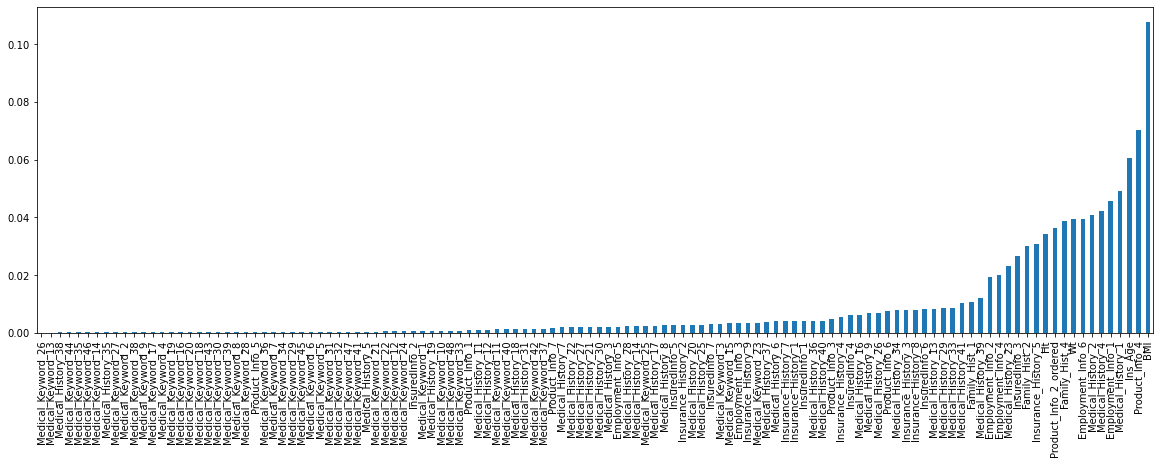

In [53]:
# get feature name and importance
features = pd.Series(model_dt.feature_importances_)
features.index = x_train.columns
# sort the features by importance
features.sort_values(ascending=True, inplace=True)
# plot
features.plot.bar(figsize=(20,6))

In [44]:
features_treebased_algorithms=pd.DataFrame(features)
features_treebased_algorithms.columns=['Feature Importance']
features_treebased_algorithms

,Feature Importance
Medical_Keyword_26,0.000088
Medical_Keyword_13,0.000094
Medical_History_38,0.000125
Medical_Keyword_44,0.000133
Medical_Keyword_35,0.000162
...,...
Employment_Info_1,0.045635
Medical_History_1,0.049208
Ins_Age,0.060458
Product_Info_4,0.070320


Feature list for Linear Algorithms:

In [63]:
features_list=anova_df['Continuousvar'].tolist()+chisquare_df['Discretevar'].tolist()

In [64]:
features_list

['Insurance_History_5',
 'Employment_Info_4',
 'Employment_Info_1',
 'Employment_Info_6',
 'Family_Hist_2',
 'Medical_History_1',
 'Family_Hist_4',
 'Ht',
 'Product_Info_4',
 'Ins_Age',
 'Wt',
 'BMI',
 'Medical_Keyword_20',
 'Medical_Keyword_2',
 'Medical_Keyword_6',
 'Medical_Keyword_39',
 'Medical_Keyword_44',
 'Medical_Keyword_26',
 'Medical_Keyword_5',
 'Medical_Keyword_8',
 'Medical_Keyword_29',
 'Product_Info_7',
 'Medical_Keyword_17',
 'Medical_Keyword_41',
 'Medical_Keyword_21',
 'Medical_Keyword_7',
 'Product_Info_5',
 'Medical_Keyword_11',
 'Medical_Keyword_14',
 'Medical_Keyword_28',
 'Medical_Keyword_13',
 'Medical_History_37',
 'Medical_Keyword_34',
 'Medical_Keyword_12',
 'Medical_Keyword_36',
 'Medical_Keyword_19',
 'Medical_History_25',
 'Medical_Keyword_18',
 'Medical_Keyword_4',
 'InsuredInfo_4',
 'Medical_History_36',
 'Medical_History_26',
 'Medical_History_14',
 'Medical_Keyword_9',
 'Product_Info_6',
 'Medical_Keyword_30',
 'Medical_History_22',
 'Medical_History_

Feature List for tree based algorithms:

In [54]:
#List of features arranged in the order of importance from low to high
#features=features[0:10]
features_list=features.index.to_list()

In [55]:
features_list

['Medical_Keyword_26',
 'Medical_Keyword_13',
 'Medical_History_38',
 'Medical_Keyword_44',
 'Medical_Keyword_35',
 'Medical_Keyword_46',
 'Medical_Keyword_14',
 'Medical_History_35',
 'Medical_Keyword_27',
 'Medical_Keyword_2',
 'Medical_Keyword_38',
 'Medical_Keyword_9',
 'Medical_Keyword_17',
 'Medical_Keyword_4',
 'Medical_Keyword_19',
 'Medical_Keyword_16',
 'Medical_Keyword_20',
 'Medical_Keyword_18',
 'Medical_Keyword_43',
 'Medical_Keyword_30',
 'Medical_Keyword_39',
 'Medical_Keyword_8',
 'Medical_Keyword_28',
 'Product_Info_5',
 'Medical_Keyword_36',
 'Medical_Keyword_7',
 'Medical_Keyword_34',
 'Medical_Keyword_29',
 'Medical_Keyword_45',
 'Medical_Keyword_6',
 'Medical_Keyword_5',
 'Medical_Keyword_31',
 'Medical_Keyword_32',
 'Medical_Keyword_47',
 'Medical_Keyword_41',
 'Medical_History_5',
 'Medical_Keyword_21',
 'Medical_Keyword_22',
 'Medical_Keyword_12',
 'Medical_Keyword_24',
 'InsuredInfo_2',
 'Medical_Keyword_1',
 'Medical_History_19',
 'Medical_Keyword_10',
 'Medi

Recursive Feature Elimination for Linear and tree based algorithms.

In [56]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features_list:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features_list))
    count = count + 1

    # initialise model
    model_int = DecisionTreeClassifier()

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        x_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        x_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    accuracy_score_int = accuracy_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((accuracy_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((accuracy_score_all)))

    # determine the drop in the roc-auc
    diff_auc = accuracy_score_all - accuracy_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if abs(diff_auc) >= tol and accuracy_score_int < accuracy_score_all:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        accuracy_score_all = accuracy_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  Medical_Keyword_26  which is feature  1  out of  120
New Test ROC AUC=0.017958695001496557
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49409928592807967
keep:  Medical_Keyword_26

testing feature:  Medical_Keyword_13  which is feature  2  out of  120
New Test ROC AUC=0.01765938341813828
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49439859751143794
keep:  Medical_Keyword_13

testing feature:  Medical_History_38  which is feature  3  out of  120
New Test ROC AUC=0.018065591995553083
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49399238893402314
keep:  Medical_History_38

testing feature:  Medical_Keyword_44  which is feature  4  out of  120
New Test ROC AUC=0.01785179800744003
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4942061829221362
keep:  Medical_Keyword_44

testing feature:  Medical_Keyword_35  which is feature  5  out of  120
New Test ROC AUC=0.01838628

New Test ROC AUC=0.017830418608628724
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4942275623209475
keep:  Medical_Keyword_12

testing feature:  Medical_Keyword_24  which is feature  40  out of  120
New Test ROC AUC=0.017466968828836534
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4945910121007397
keep:  Medical_Keyword_24

testing feature:  InsuredInfo_2  which is feature  41  out of  120
New Test ROC AUC=0.017317313037157396
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49474066789241883
keep:  InsuredInfo_2

testing feature:  Medical_Keyword_1  which is feature  42  out of  120
New Test ROC AUC=0.01819386838842092
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4938641125411553
keep:  Medical_Keyword_1

testing feature:  Medical_History_19  which is feature  43  out of  120
New Test ROC AUC=0.018086971394364392
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49397100953521184
keep:  Medical_History_19

New Test ROC AUC=0.018151109590798308
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4939068713387779
keep:  Insurance_History_9

testing feature:  Medical_Keyword_23  which is feature  78  out of  120
New Test ROC AUC=0.018728353358703553
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4933296275708727
keep:  Medical_Keyword_23

testing feature:  Medical_History_37  which is feature  79  out of  120
New Test ROC AUC=0.01748834822764784
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4945696327019284
keep:  Medical_History_37

testing feature:  Medical_History_6  which is feature  80  out of  120
New Test ROC AUC=0.017552486424081755
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49450549450549447
keep:  Medical_History_6

testing feature:  Insurance_History_7  which is feature  81  out of  120
New Test ROC AUC=0.01855731816821311
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4935006627613631
keep:  Insuranc

New Test ROC AUC=0.018258006584854835
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4937999743447214
keep:  Employment_Info_1

testing feature:  Medical_History_1  which is feature  117  out of  120
New Test ROC AUC=0.018813870953948774
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49324410997562745
keep:  Medical_History_1

testing feature:  Ins_Age  which is feature  118  out of  120
New Test ROC AUC=0.018535938769401804
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4935220421601744
keep:  Ins_Age

testing feature:  Product_Info_4  which is feature  119  out of  120
New Test ROC AUC=0.019027664942061828
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.4930303159875144
keep:  Product_Info_4

testing feature:  BMI  which is feature  120  out of  120
New Test ROC AUC=0.018493179971779194
All features Test ROC AUC=0.5120579809295762
Drop in ROC AUC=0.49356480095779703
keep:  BMI
DONE!!
total features to remove:  0
total fea

In [143]:
col_list=features_to_keep

In [144]:
#Lets use only these features for modelling and check if accuracy improves
model_dt.fit(x_train.loc[:,col_list],y_train)
y_pred=model_dt.predict(x_test.loc[:,col_list])

In [146]:
!pip install shap

In [148]:
import shap

In [ ]:
explainer = shap.Explainer(model_dt)
shap_values = explainer(X_over_sample)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])